<a href="https://colab.research.google.com/github/sidharkal/AIorNOT-by-Hugging-Face/blob/main/Ai_or_Not_Efficientnet_with_focal_lossipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive

#drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Huggingface /Ai NotAI/train.zip", 'r')
zip_ref.extractall("")
zip_ref.close()

In [2]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Huggingface /Ai NotAI/test.zip", 'r')
zip_ref.extractall("")
zip_ref.close()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from keras import backend as K
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Huggingface /Ai NotAI/train.csv',dtype={'label': str})
sample =  pd.read_csv('/content/sample_submission.csv',dtype={'label': str})
train.head()

,id,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,0
4,4.jpg,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18618 entries, 0 to 18617
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18618 non-null  object
 1   label   18618 non-null  object
dtypes: object(2)
memory usage: 291.0+ KB


In [6]:
train.shape,sample.shape

((18618, 2), (43442, 2))

In [7]:
train['label'].value_counts()

1    10330
0     8288
Name: label, dtype: int64

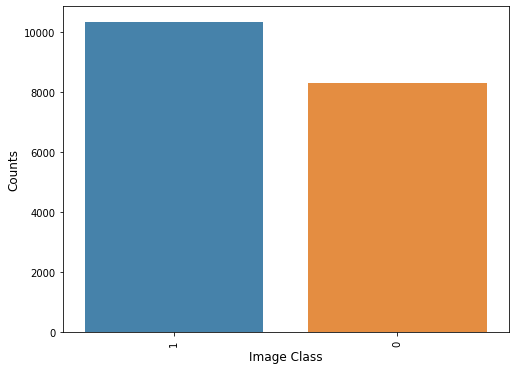

In [8]:
label_counts = train.label.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [9]:
src_path_train = "/content/train/"
src_path_test = "/content/test/"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [10]:
batch_size = 32
IMAGE_SHAPE = (300, 300)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="id",
    y_col="label",
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="id",
    y_col="label",
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode="binary",
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample,
    directory=src_path_test,
    x_col="id",
    target_size=(300, 300),
    batch_size=16,
    class_mode=None,
    shuffle=False,
)

Found 14895 validated image filenames belonging to 2 classes.
Found 3723 validated image filenames belonging to 2 classes.
Found 43442 validated image filenames.


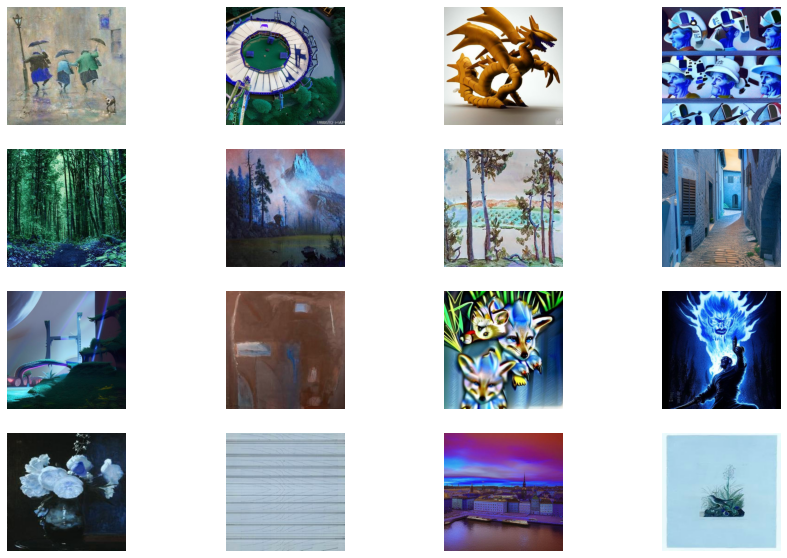

In [11]:
rand_images = random.sample(os.listdir(src_path_train), 16)

fig = plt.figure(figsize=(15,10))
for i, im in enumerate(rand_images):
    plt.subplot(4,4, i+1)
    im = cv2.imread(os.path.join(src_path_train, im))
    im = cv2.resize(im, (300,300))
    plt.imshow(im)
    plt.axis('off')
    
plt.show()

In [12]:
# Original: EfficientNetB3 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1"

def create_model(model_url, num_classes=1):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,                  # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape= IMAGE_SHAPE+(3,))    # define the input image shape
  
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
      ])
    return model

In [13]:
def focal_loss(y_true, y_pred):
    gamma = 2.0,
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [14]:
# Create model
model = create_model(model_url=efficientnet_url,num_classes=1)

# Compile EfficientNet model
model.compile(loss=focal_loss,optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
# fit the model
history = model.fit(train_generator,
                    epochs=7,
                    steps_per_epoch=len(train_generator),
                    validation_data=valid_generator,   
                    validation_steps=len(valid_generator)) 

Epoch 1/7
466/466 [==============================] - 520s 1s/step - loss: 1.2099 - accuracy: 0.8154 - val_loss: 0.9957 - val_accuracy: 0.8262
Epoch 2/7
466/466 [==============================] - 467s 1s/step - loss: 0.9773 - accuracy: 0.8596 - val_loss: 0.9252 - val_accuracy: 0.8687
Epoch 3/7
466/466 [==============================] - 513s 1s/step - loss: 0.8985 - accuracy: 0.8708 - val_loss: 0.9103 - val_accuracy: 0.8598
Epoch 4/7
466/466 [==============================] - 464s 996ms/step - loss: 0.8713 - accuracy: 0.8762 - val_loss: 0.9238 - val_accuracy: 0.8571
Epoch 5/7
466/466 [==============================] - 462s 991ms/step - loss: 0.8455 - accuracy: 0.8800 - val_loss: 0.8793 - val_accuracy: 0.8740
Epoch 6/7
466/466 [==============================] - 513s 1s/step - loss: 0.8295 - accuracy: 0.8820 - val_loss: 0.9224 - val_accuracy: 0.8523
Epoch 7/7
466/466 [==============================] - 458s 983ms/step - loss: 0.8113 - accuracy: 0.8870 - val_loss: 0.8842 - val_accuracy: 0.87

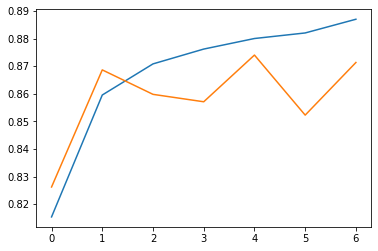

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  
plt.show()

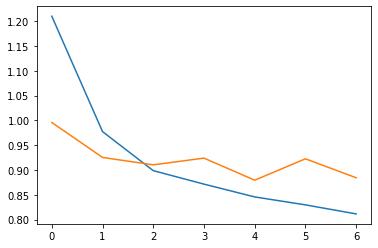

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [19]:
score = model.evaluate_generator(valid_generator)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8758512735366821
Test accuracy: 0.8745635151863098


In [20]:
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))

In [21]:
predict[:5]

array([[0.38727883],
       [0.32499614],
       [0.03729013],
       [0.3890676 ],
       [0.48538926]], dtype=float32)

In [22]:
prediction = [i[0] for i in predict]
#prediction = [1 if i[0] >0.5 else 0 for i in predict]

In [23]:
# make submission
submission = pd.DataFrame({'id':sample['id'], 'label':prediction})
submission.to_csv('submission.csv', index=False)

In [24]:
submission.head()

,id,label
0,0.jpg,0.387279
1,1.jpg,0.324996
2,10.jpg,0.037290
3,100.jpg,0.389068
4,1000.jpg,0.485389
